In [15]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import requests
from pprint import pprint

# Import csv broadband data to dataframe
broadband_df = pd.read_csv("CSV_files/clean_broadband.csv")

# Census API Key
from config import census_api_key

In [16]:
# Assume year is 2017

# Craft base url
base_url = "https://api.census.gov/data/2017/ecnbasic"

# Craft query url
query_url = base_url + f"?get=NAICS2017_LABEL,EMP,NAME,GEO_ID&for=county:*&NAICS2017=51&key={census_api_key}"

# Grabs relevant data from census
response = requests.get(query_url).json()

In [17]:
# Initialize empty arrays
NAICS2017_label = []
number_employed = []
county_name = []
GEO_ID = []

# Creates arrays by appending relevant data to array,which maintains index.
for county in response:
    NAICS2017_label.append(county[0])
    number_employed.append(county[1])
    county_name.append(county[2])
    GEO_ID.append(county[3])
    
# Arrays are compiled into a dataframe
county_2017_df = pd.DataFrame({"NAICS2017 Label":NAICS2017_label,
                              "Number Employed":number_employed,
                              "County, State":county_name,
                              "GEO ID":GEO_ID})

# As the first row of the dataframe is the labels from the Census, it must be dropped.
county_2017_df.drop(index=0,inplace=True)

# Output the resulting array.
county_2017_df.head()

,NAICS2017 Label,Number Employed,"County, State",GEO ID
1,Information,0,"Benton County, Tennessee",0500000US47005
2,Information,199,"Warren County, Tennessee",0500000US47177
3,Information,1424,"Washington County, Tennessee",0500000US47179
4,Information,131,"Weakley County, Tennessee",0500000US47183
5,Information,0,"Campbell County, Tennessee",0500000US47013


In [18]:
# 2017 Broadband dataframe is crafted only grabbing relevant columns to prevent clutter
broadband_2017_df = broadband_df.loc[broadband_df["Year"] == 2017][["Broadband (%)","GEO ID","Year"]]

# Broadband dataframe is combined with county 2017 data from census.  Inner merge is used to drop all empty data points.
combined_2017_df = county_2017_df.merge(broadband_2017_df, how="inner", on="GEO ID")

# Data is output to screen and as a csv.
combined_2017_df.to_csv(f'CSV_files/{combined_2017_df["Year"].min()}_{combined_2017_df["NAICS2017 Label"].min()}_ecnbasic.csv',
                        index=False)
combined_2017_df.head()

,NAICS2017 Label,Number Employed,"County, State",GEO ID,Broadband (%),Year
0,Information,0,"Benton County, Tennessee",0500000US47005,56.153846,2017
1,Information,199,"Warren County, Tennessee",0500000US47177,56.739813,2017
2,Information,1424,"Washington County, Tennessee",0500000US47179,85.897809,2017
3,Information,131,"Weakley County, Tennessee",0500000US47183,62.890625,2017
4,Information,0,"Campbell County, Tennessee",0500000US47013,55.232561,2017


In [19]:
# Above is the work done to ensure the program works.  The below is a version that grabs a collection of dataframes based upon
#    NAICS labels.

# List of single labels to examine for all that the census has data on that doesn't crash.
# This was done by looking at census documentation, writing out each NAICS label into a list, and removing values that crashed
# The original list was [21,22,23,31,32,33,42,44,45,48,49,51,52,53,54,55,56,61,62,71,72,81]
NAICS_list = [22,51,52,53,54,56,61,62,71,72,81]

# Assume year is 2017
# Grab csv for acs5 in 2017 then cut out all irrelevant columns
acs5_data = pd.read_csv("CSV_files/acs5_2017.csv")
acs5_df = acs5_data[["Name","Population"]]


# Craft base url
base_url = "https://api.census.gov/data/2017/ecnbasic"

# Empty list of file paths and total number employed in label are made
NAICS_2017_csv_paths = []

for label in NAICS_list:
    
    # As this label is printed first, if a csv is crafted, the next number appears. Otherwise, the last label crashed it.
    print(label)
 
    # query url is crafted
    query_url = base_url + f"?get=NAICS2017_LABEL,EMP,NAME,GEO_ID&for=county:*&NAICS2017={label}&key={census_api_key}"
   
    # census is called
    response = requests.get(query_url).json()
    
    # Initialize empty arrays
    NAICS2017_label = []
    number_employed = []
    county_name = []
    GEO_ID = []

    # Creates arrays by appending relevant data to array,which maintains index.
    for county in response:
        NAICS2017_label.append(county[0])
        number_employed.append(county[1])
        county_name.append(county[2])
        GEO_ID.append(county[3])
    
    # Arrays are compiled into a dataframe
    county_2017_data = pd.DataFrame({"NAICS2017 Label":NAICS2017_label,
                                  "Number Employed":number_employed,
                                  "Name":county_name,
                                  "GEO ID":GEO_ID})
    
    # Population data is merged into dataframe
    county_2017_df = pd.DataFrame.merge(county_2017_data ,acs5_df, how="inner")

    # As the first row of the dataframe is the labels from the Census, it must be dropped.
    county_2017_df.drop(index=0,inplace=True)
    
    # 2017 Broadband dataframe is crafted only grabbing relevant columns to prevent clutter
    broadband_2017_df = broadband_df.loc[broadband_df["Year"] == 2017][["Broadband (%)","GEO ID","Year"]]

    # Broadband dataframe is combined with county 2017 data from census.  Inner merge is used to drop all empty data points.
    combined_2017_df = county_2017_df.merge(broadband_2017_df, how="inner", on="GEO ID")


    # Column needed for math is saved as int to ensure math and not concatenation
    # Total number employed in label is appended to relevant array
    # New column for percent employed in label is calculated then made into new column for combined dataframe
    combined_2017_df["Number Employed"] = combined_2017_df["Number Employed"].astype(float)
    combined_2017_df["Percent Employed"] = 100 * combined_2017_df["Number Employed"] / combined_2017_df["Population"]
    
    # Data is saved as a csv.
    combined_2017_df.to_csv(f'CSV_files/{combined_2017_df["Year"].min()}_{combined_2017_df["NAICS2017 Label"].min()}_ecnbasic.csv',
                            index=False)
    
    # File path for csv file just written to is appended to relevant array
    NAICS_2017_csv_paths.append(f'CSV_files/{combined_2017_df["Year"].min()}_{combined_2017_df["NAICS2017 Label"].min()}_ecnbasic.csv')

    
    # Did the loop finish?
    print("Successfully retrieved")
    
# List of csv paths is turned into a dataframe then saved as a csv.
NAICS_2017_csv_paths_df = pd.DataFrame({"Paths": NAICS_2017_csv_paths})
NAICS_2017_csv_paths_df.to_csv(f'CSV_files/NAICS_2017_csv_paths.csv', index=False) 

22
Successfully retrieved
51
Successfully retrieved
52
Successfully retrieved
53
Successfully retrieved
54
Successfully retrieved
56
Successfully retrieved
61
Successfully retrieved
62
Successfully retrieved
71
Successfully retrieved
72
Successfully retrieved
81
Successfully retrieved


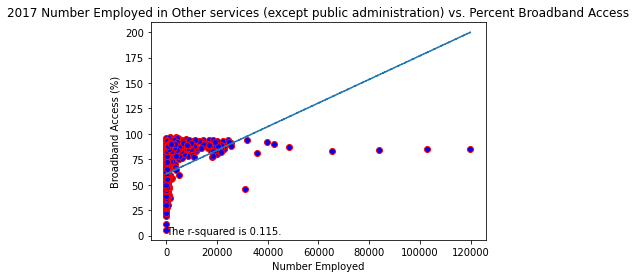

In [20]:
# This section runs a linear regression for all NAICS labels and broadband access

# for loop looping through all paths created in previous steps analyzes all files based upon number employed vs broadband access
#    for a specific NAICS label.
for path in NAICS_2017_csv_paths_df["Paths"]:
    
    # Clears figure so plots do not superimpose
    plt.clf()
    
    # Dataframe for relevant label is made
    label_df = pd.read_csv(path)
    
    # Lists for x and y values are defined
    x = label_df['Number Employed']
    y = label_df['Broadband (%)']

    # Linear regression is run
    label_slope, label_int, label_r, p, std_err = stats.linregress(x ,y)
    label_fit = label_slope * x + label_int

    # Plot is crafted and labeled then linear regression and r-squared are superimposed
    plt.scatter(x ,y , marker="o", facecolors="blue", edgecolors="red")
    plt.title(f'{label_df["Year"].min()} Number Employed in {label_df["NAICS2017 Label"].min()} vs. Percent Broadband Access')
    plt.xlabel("Number Employed")
    plt.ylabel("Broadband Access (%)")
    plt.plot(x , label_fit,"--")
    plt.text(0,1.2,f'The r-squared is {round(label_r**2,3)}.')

    # plot is output and saved as a png
    plt.savefig(f'output_charts/{label_df["Year"].min()}_NAICS_{label_df["NAICS2017 Label"].min()}_lin_regress.png',format='png')

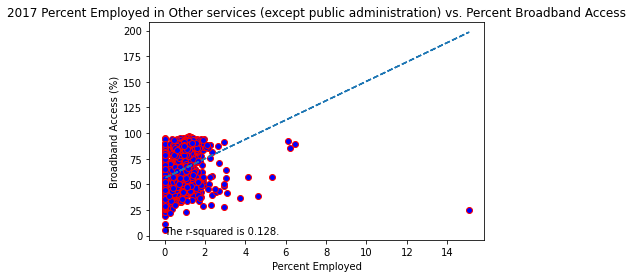

In [21]:
# Previous linear regression appears to be primarily a population map, so here we examine the percent employed by each industry.

# for loop to examine for all paths
for path in NAICS_2017_csv_paths_df["Paths"]:
    
    # Clears figure so plots do not superimpose
    plt.clf()
    
    # Dataframe for relevant label is made
    label_df = pd.read_csv(path)
    
    # Lists for x and y values are defined
    x = label_df['Percent Employed']
    y = label_df['Broadband (%)']

    # Linear regression is run
    label_slope, label_int, label_r, p, std_err = stats.linregress(x ,y)
    label_fit = label_slope * x + label_int

    # Plot is crafted and labeled then linear regression and r-squared is superimposed
    plt.scatter(x ,y , marker="o", facecolors="blue", edgecolors="red")
    plt.title(f'{label_df["Year"].min()} Percent Employed in {label_df["NAICS2017 Label"].min()} vs. Percent Broadband Access')
    plt.xlabel("Percent Employed")
    plt.ylabel("Broadband Access (%)")
    plt.plot(x , label_fit,"--")
    plt.text(0,1,f'The r-squared is {round(label_r**2,3)}.')

    # plot is output and saved as a png
    plt.savefig(f'output_charts/{label_df["Year"].min()}_NAICS_{label_df["NAICS2017 Label"].min()}_lin_regress_percent_employed.png',format='png')